# Classifying Edible vs Poisonous Mushroom 

Using Fast.ai to build edible vs Poisonous Mushroom. 

In [21]:
!pip install fastbook fastai fastdownload

# Import packages

In [22]:
from fastbook import *
from fastai.vision.widgets import *
from fastdownload import *
from pathlib import Path
from PIL import Image

# Define category & download images to dest

In [23]:
searches = 'poisonous', 'edible'
path = Path('mushroom')

# add this if rerun or presumably path has already been created
if not path.exists():
    path.mkdir(exist_ok=True)

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} mushroom')
    #urls = results.attrgot('contentUrl') - for first run
    #this is for rerun if you run all after the first time
    urls=results
    # Filter out None values
    urls = [url for url in urls if url is not None]
    download_images(dest, urls=urls)
    print(f'Downloaded images for {o} mushroom')    

Downloaded images for poisonous mushroom
Downloaded images for edible mushroom


# Verify & Drop Failed Images

In [24]:
# get the images 
imp = get_image_files(path)

#verify if any images in the file 
if imp:
    print("Yeap, images are well stored")
else:
    print("No images found in directory")

Yeap, images are well stored


In [25]:
# check failed images
failed = verify_images(imp)
print("Total failed images:",len(failed))

Total failed images: 6


In [26]:
# drop images
failed.map(Path.unlink)

(#6) [None,None,None,None,None,None]

In [27]:
len(imp)

350

# Preprocessing using Data Block & Split (T&V) using Data Loaders

Note to self:
    Defines a DataBlock to specify data loading and preprocessing steps.

* ImageBlock: Input is an image.
* CategoryBlock: Output is a category (bear type).
* get_items: Function to retrieve image files.
* splitter: Splits data into training and validation sets.
* get_y: Function to extract labels from file paths.
* item_tfms: Transformations applied to individual images (resizing)

Creates dataloaders for training and validation.

In [28]:
#create Datablock
mushrooms = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=57),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')] 
)

In [29]:
#create DataLoaders

dls = mushrooms.dataloaders(path)

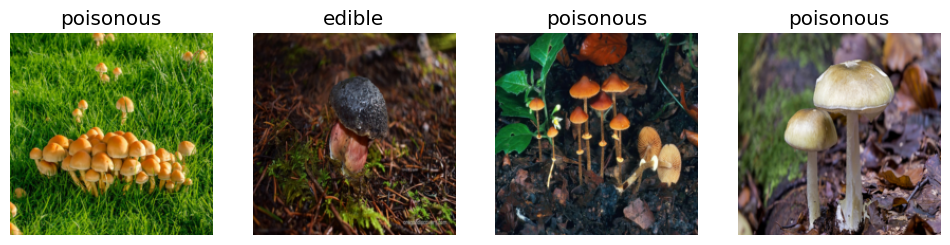

In [33]:
# view validation sets
dls.valid.show_batch(max_n =4, nrows=1)

# Model Training 

In [32]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.244349,0.902226,0.338235,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.789035,0.605166,0.294118,00:40
1,0.661567,0.783579,0.323529,00:40
2,0.541666,0.890078,0.338235,00:41
3,0.452383,0.904957,0.338235,00:41


# Model Evaluation 

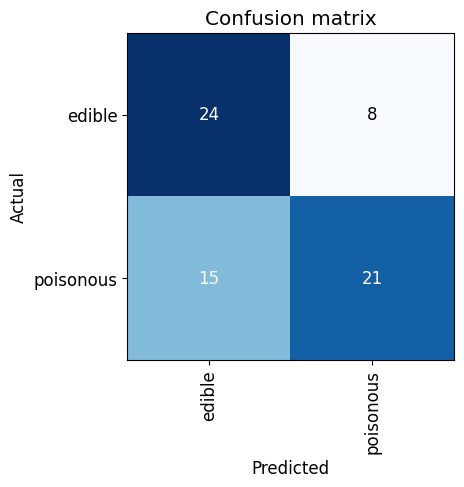

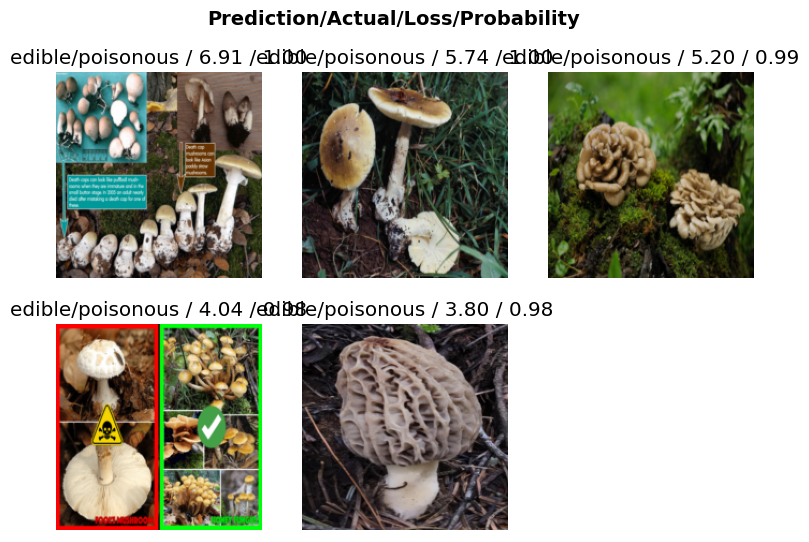

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=5, nrows=2)

# Using Data Augmentation to transform Data and retrain new model 
Owing to confusion matrix are rather high in validation set, we are using aug_transforms to improve accuracy

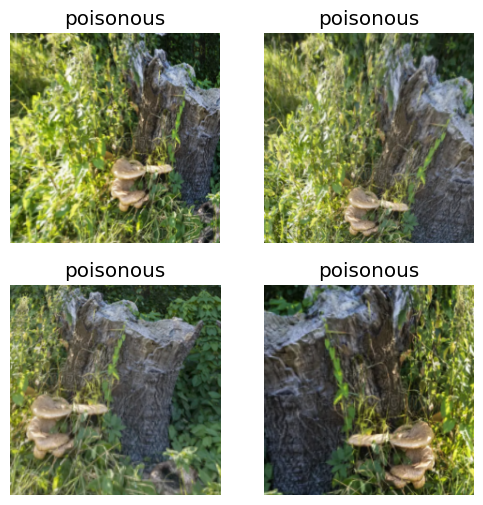

In [41]:
aug_mush =  mushrooms.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = aug_mush.dataloaders(path)
dls.train.show_batch(max_n=4, unique=True)

In [43]:
learn2 = vision_learner(dls, resnet18, metrics=error_rate)
learn2.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.263114,1.066702,0.382353,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.826939,0.871579,0.367647,00:53
1,0.760323,0.878581,0.323529,00:53
2,0.678567,0.928370,0.294118,00:54
3,0.618683,0.939456,0.294118,00:53


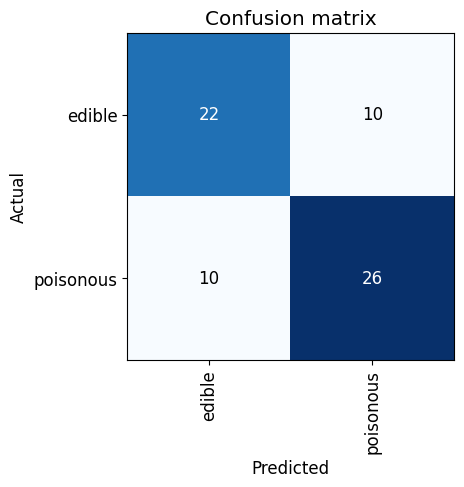

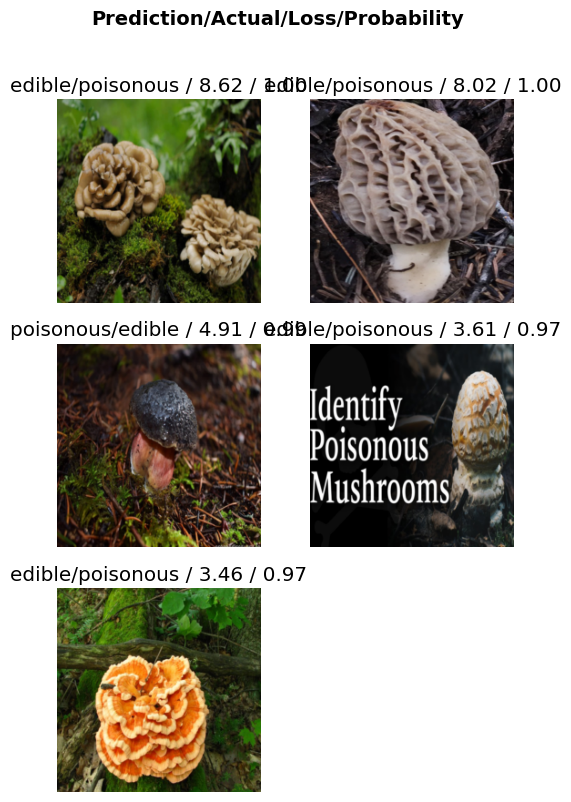

In [45]:
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=5, nrows=3)

In [47]:
#i am not going to alter this, as i am not mushroom expect, however note to self
cleaner = ImageClassifierCleaner(learn2)
cleaner

# Export Model

In [48]:
learn2.export()

In [51]:
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [52]:
learn2_inf = load_learner(path/'export.pkl')

In [61]:
#predict mushroom images
ps_mush = download_url('https://blog.uvahealth.com/wp-content/uploads/2017/02/poisonousmushrooms.slideshow.jpg')
learn2_inf.predict(ps_mush)

('poisonous', tensor(1), tensor([0.0793, 0.9207]))

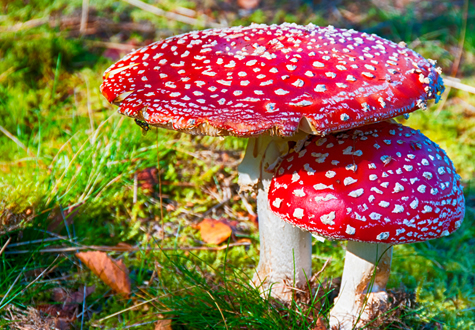

In [62]:
#as shown above classifier has identify this image as poisonous, let's see how this mushroom looks like
Image.open(ps_mush)

In [64]:
#predict another one
shitake = download_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTeRSzWyE_xAUfYQMNoy0zL0lcOWVvQTqhUjQ&s')
learn2_inf.predict(shitake)

('edible', tensor(0), tensor([0.9891, 0.0109]))

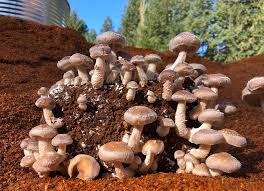

In [65]:
#what's this?
Image.open(shitake)

So Des ka!? The image above shown mushroom species "Amanita". As google search, Amanita is highly poisonous and may cause death after consumption. That's a well done! Finally mushroom classifier has well learnt. 

And Shitake mushroom, trust you have tried it in some delicacy.

# Disclaimer**

**THIS IS NOT A WORKABLE CLASSIFIER**

This model was developed for educational purposes to explore image classification techniques. It is **NOT** a reliable tool for identifying edible mushrooms. **Under no circumstances should you consume a mushroom based on this model's predictions.** Mushroom identification requires expert knowledge, and misidentification can lead to severe poisoning or death. Always consult with a qualified mycologist.